## Mercari Price Suggestion Challenge

The objective of this challenge is to build an algorithm that automatically suggests the right product prices on Mercari. The training data consists of user-inputted text descriptions of their products, including details like product category name, brand name, and item condition

In [35]:
# Import required libraries
import numpy as np
import pandas as pd
import string
import re
import pickle

# Text mining 
import nltk
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction import stop_words
from sklearn.decomposition import TruncatedSVD

# Time 
from time import time

#Plots
import matplotlib.pyplot as plt


## Exploratory Data Analysis

In [36]:
def startTime():
    return time()
def endTime(s):
    print "Time elapsed {}".format(-s+time())


In [37]:
train_df = pd.read_csv('../../data/train.tsv', sep='\t')
#test = pd.read_csv('../../data/test.tsv', sep='\t')

In [38]:
# size of training and dataset
print(train_df.shape)

(593376, 8)


In [39]:
# different data types in the dataset: categorical (strings) and numeric
train_df.dtypes


train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [40]:
# Overall summary of train data
train_df.describe()

,train_id,item_condition_id,price,shipping
count,593376.000000,593376.000000,593376.000000,593376.000000
mean,296687.500000,1.907738,26.689003,0.446294
std,171293.041002,0.902921,38.340061,0.497108
min,0.000000,1.000000,0.000000,0.000000
25%,148343.750000,1.000000,10.000000,0.000000
50%,296687.500000,2.000000,17.000000,0.000000
75%,445031.250000,3.000000,29.000000,1.000000
max,593375.000000,5.000000,2000.000000,1.000000


In [41]:
# First few rows of the dataset 
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [42]:
# Retain only part of the data 
n_samples = 10000
train_df = train_df.iloc[:n_samples,:]
print(train_df.shape)

(10000, 8)


In [43]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [44]:
stop = set(stopwords.words('english'))
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

In [45]:
n_features = 1000

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(min_df=10,
                             max_features=180000,
                             tokenizer=tokenize,
                             ngram_range=(1, 2))

t0 = startTime()
tfidf = tfidf_vectorizer.fit_transform(train_df['item_description'].apply(str))
endTime(t0)

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer_lda = CountVectorizer(min_df=4,max_features=180000,
                     tokenizer=tokenize,ngram_range=(1,2))
t0 = startTime()
tfidf_lda = tf_vectorizer_lda.fit_transform(train_df['item_description'].apply(str))
endTime(t0)

Extracting tf-idf features for NMF...
Time elapsed 6.58200001717
Extracting tf features for LDA...
Time elapsed 6.68400001526


In [46]:
n_components = 10
n_top_words = 10

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf_frob = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf_frob, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf_kld = NMF(n_components=n_components, random_state=1,
          beta_loss= 'kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf_kld, tfidf_feature_names, n_top_words)


print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

lda = LatentDirichletAllocation(n_components=n_components, max_iter=20,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tfidf_lda)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer_lda.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=10000 and n_features=1000...
done in 2.718s.

Topics in NMF model (Frobenius norm):
Topic #0: description yet yet description ❌no going good condition good gone golf golden
Topic #1: brand new brand new new never tags box new tags new box sealed new sealed
Topic #2: size small medium size small size medium large black size large pink top
Topic #3: worn never worn never new never times worn times worn size washed worn twice cute
Topic #4: great great condition condition worn great excellent excellent condition condition size times perfect condition times great
Topic #5: shipping free shipping free bundle price firm price firm please save items
Topic #6: used never used never new never opened gently used gently never opened used condition box
Topic #7: new like new like box new box tags new tags new condition authentic without
Topic #8: good good condition condition excellent excellent condition size good condition si

In [47]:

tfidf_dict = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer.idf_))

In [48]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(tfidf)
train_svd = pd.DataFrame(svd_obj.transform(tfidf))

In [49]:
train_svd.shape

(10000, 20)

In [50]:
lda_trans = lda.transform(tfidf_lda)
nmf_frob_trans = nmf_frob.transform(tfidf)
nmf_kld_trans = nmf_kld.transform(tfidf)

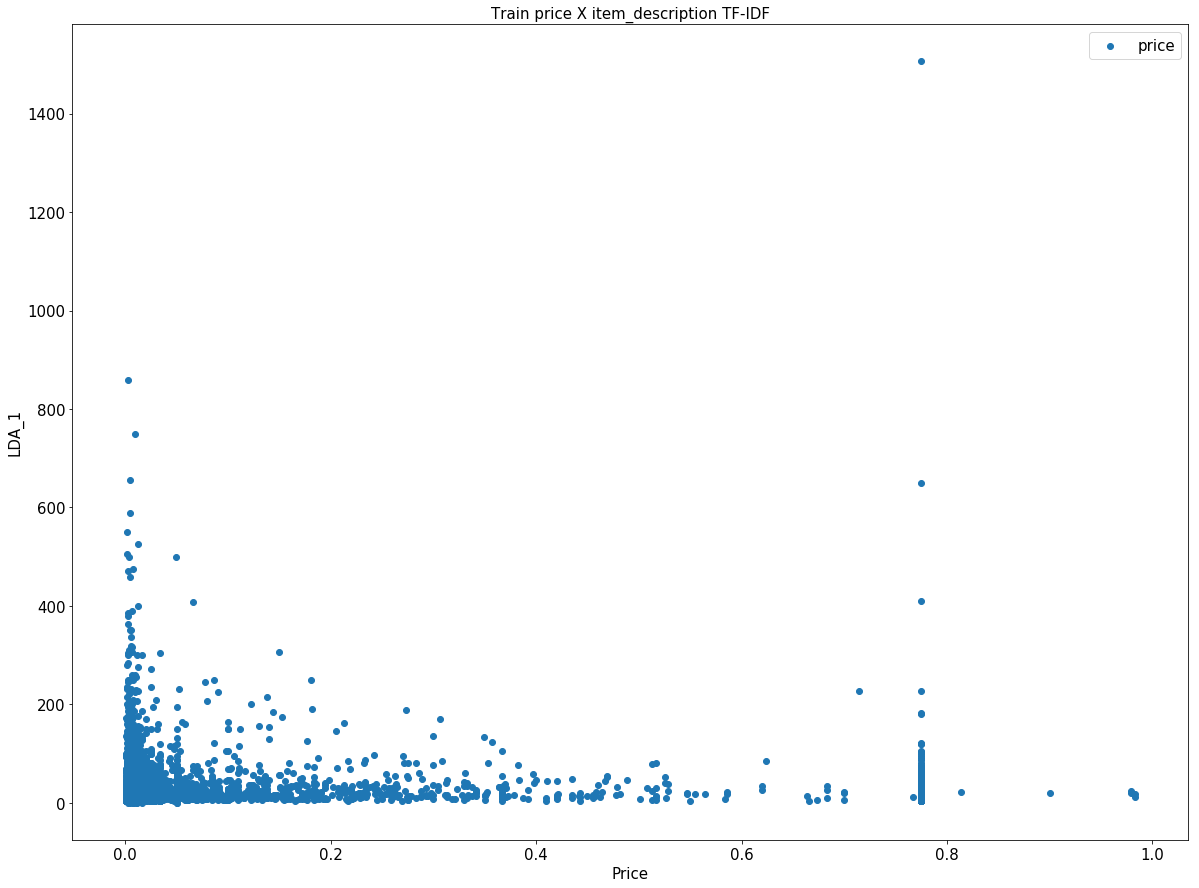

In [58]:
train_df['lda'] = np.array(lda_trans)[:,0]
plt.figure(figsize=(20, 15))
plt.scatter(train_df['lda'], train_df['price'])
plt.title('Train price X item_description TF-IDF', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('LDA_1', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()


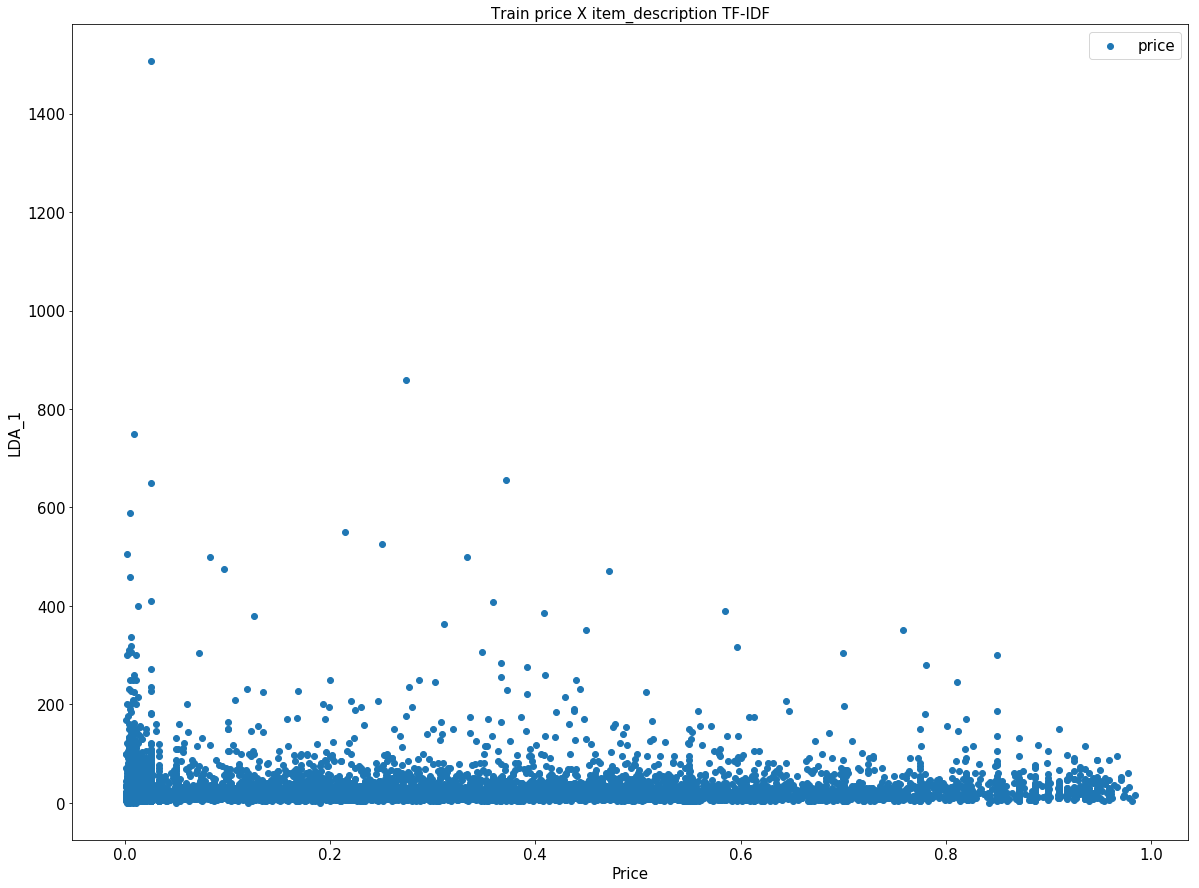

In [59]:
train_df['lda'] = np.array(lda_trans)[:,1]
plt.figure(figsize=(20, 15))
plt.scatter(train_df['lda'], train_df['price'])
plt.title('Train price X item_description TF-IDF', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('LDA_1', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()


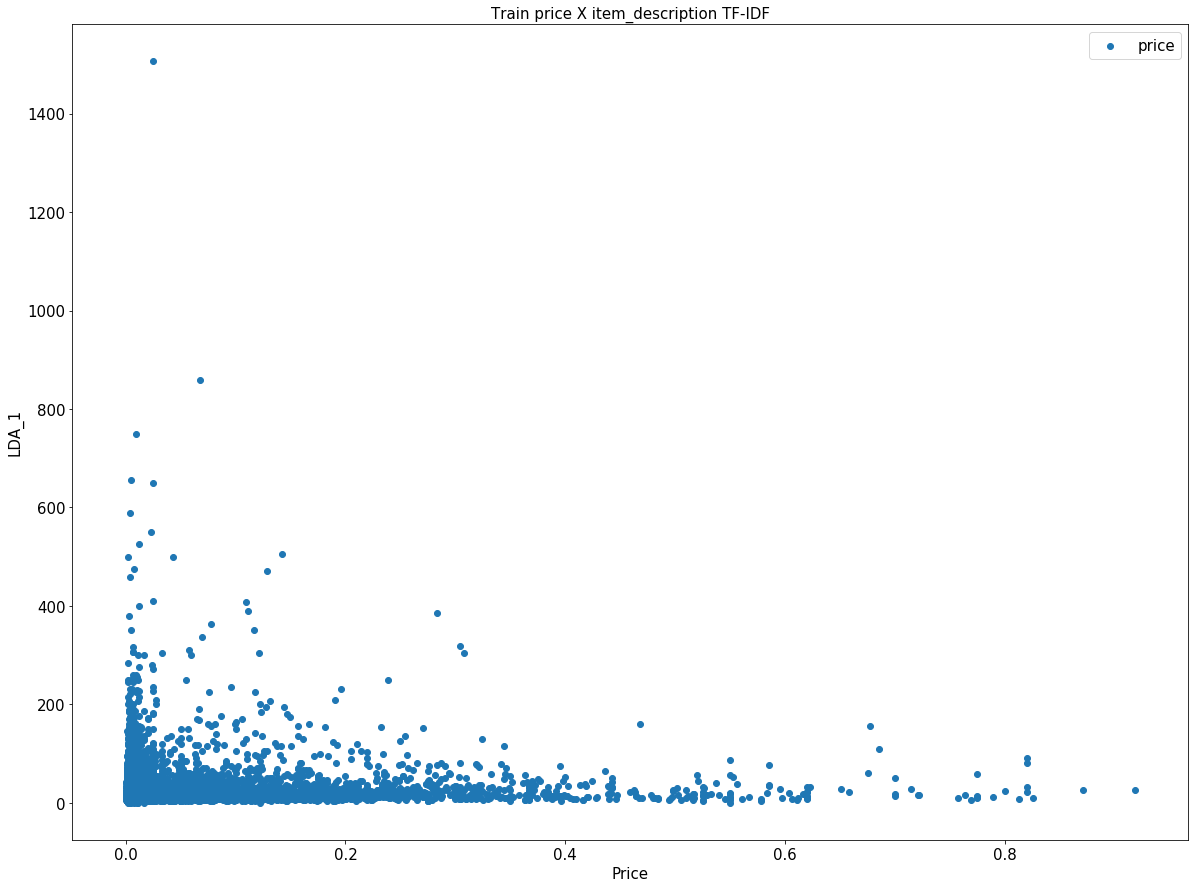

In [60]:
train_df['lda'] = np.array(lda_trans)[:,2]
plt.figure(figsize=(20, 15))
plt.scatter(train_df['lda'], train_df['price'])
plt.title('Train price X item_description TF-IDF', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('LDA_1', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()


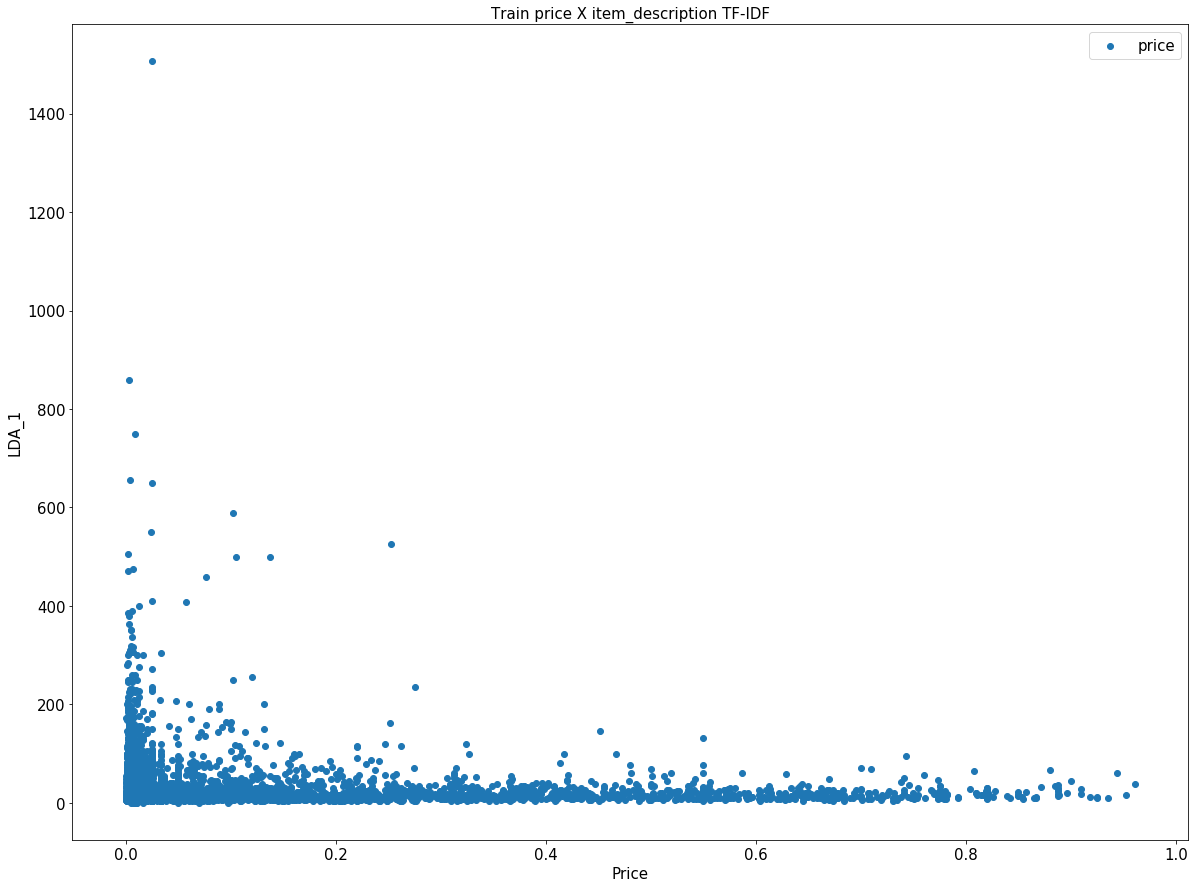

In [61]:
train_df['lda'] = np.array(lda_trans)[:,3]
plt.figure(figsize=(20, 15))
plt.scatter(train_df['lda'], train_df['price'])
plt.title('Train price X item_description TF-IDF', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('LDA_1', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()



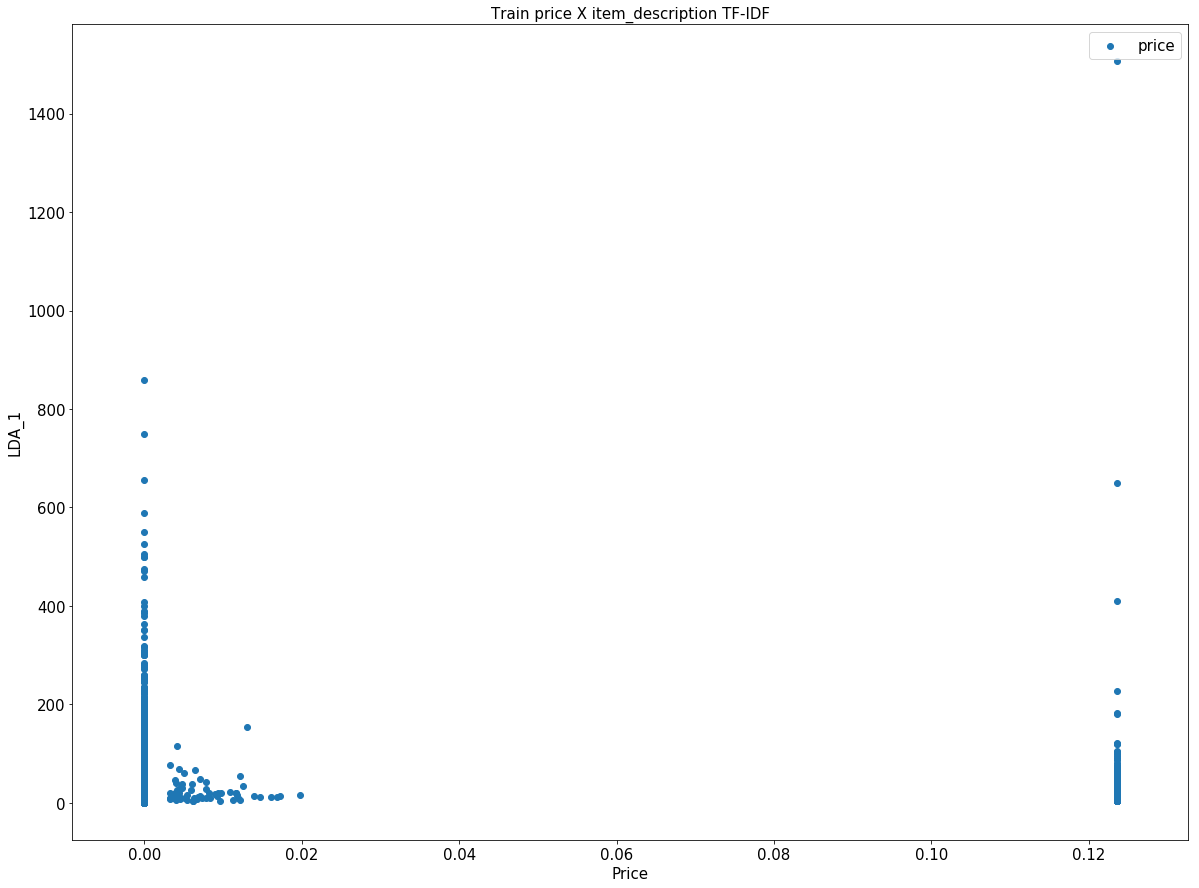

In [62]:
train_df['nmf'] = np.array(nmf_frob_trans)[:,0]
plt.figure(figsize=(20, 15))
plt.scatter(train_df['nmf'], train_df['price'])
plt.title('Train price X item_description TF-IDF', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('LDA_1', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()


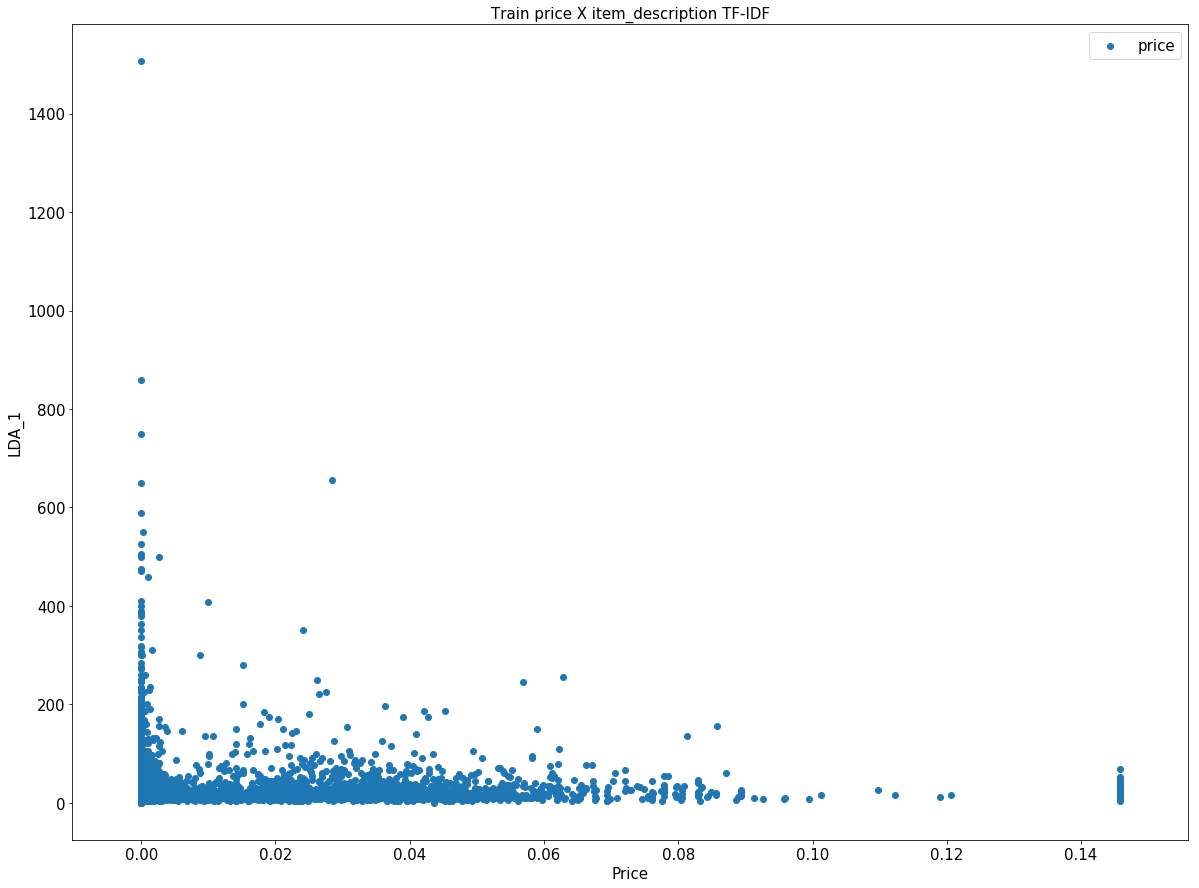

In [63]:
train_df['nmf'] = np.array(nmf_frob_trans)[:,1]
plt.figure(figsize=(20, 15))
plt.scatter(train_df['nmf'], train_df['price'])
plt.title('Train price X item_description TF-IDF', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('LDA_1', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()


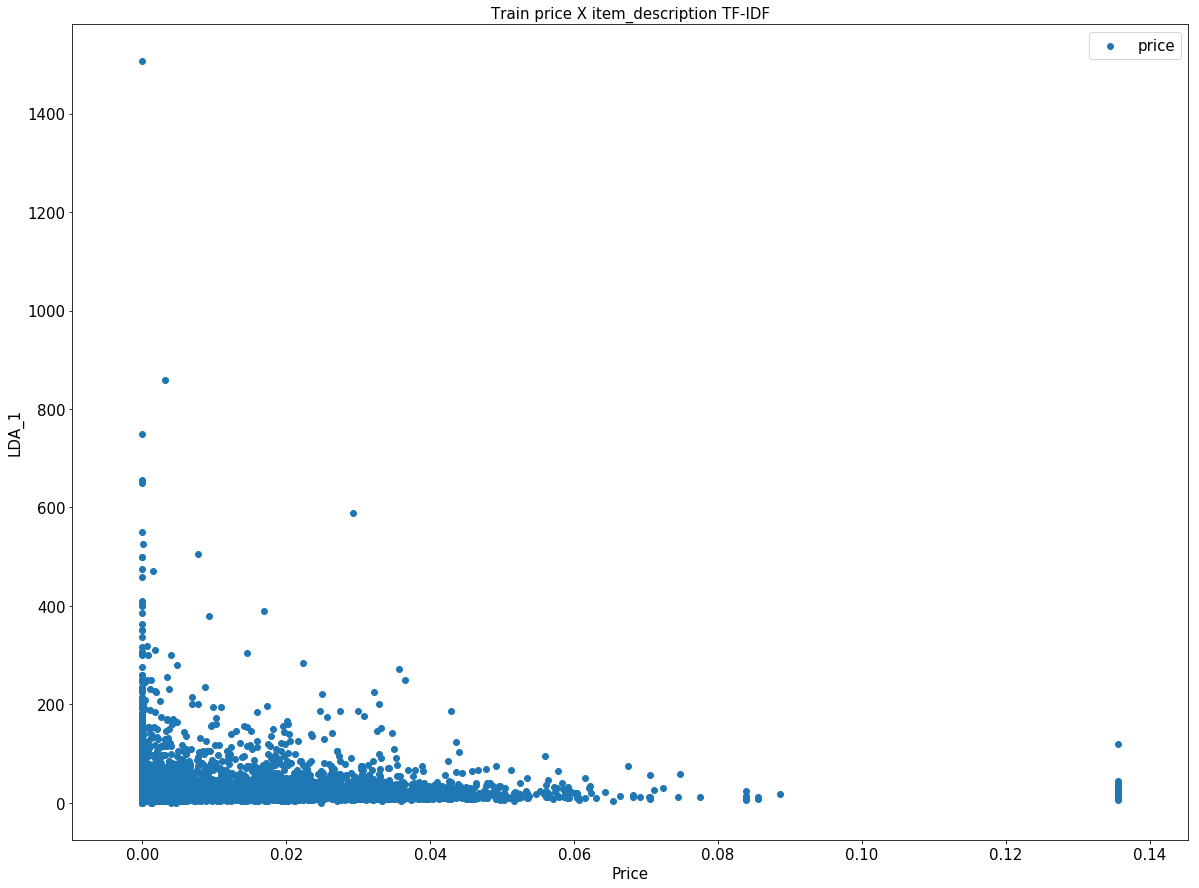

In [64]:
train_df['nmf'] = np.array(nmf_frob_trans)[:,2]
plt.figure(figsize=(20, 15))
plt.scatter(train_df['nmf'], train_df['price'])
plt.title('Train price X item_description TF-IDF', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('LDA_1', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()
